# C14-hepatocyte analysis

default_parameters -> fit

default_limit -> physical

parameters -> physical

In [1]:
import datetime
from IPython.display import display
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import warnings

%matplotlib inline

mem = joblib.Memory(location='~/tmp/hepato/', verbose=0)

import logging

%load_ext rpy2.ipython

# logging.basicConfig(filename='c14.log',
#                              filemode='a',
#                              format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
#                             datefmt='%H:%M:%S',
#                              level=logging.DEBUG)
logging.basicConfig(level=logging.WARNING)

In [2]:
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

In [3]:
# %load_ext autoreload
# %autoreload 2
import c14
import c14.models.liver
import c14.models.minimal

## Data

In [4]:
data = pd.read_csv('../data/C14data_liver_samples_20200129.csv')
data = data.groupby(['type', 'sample', 'ploidy', 'pathology']).mean().dropna(how='all').reset_index()
data['age'] = data['Dcoll'] - data['Dbirth']
data = data.query('type == "hepatocyte" and pathology != "Y"')
edata = c14.exp_data(data)

## Fit the models

In [5]:
@mem.cache
def fit_model(edata, model, step_size=0.1, optimize_minuit_multistart_kwargs=dict(n=100,processes=8)):
    print(f'Fitting model {model.__name__}')
    result = {'model': model()}
    result['op'] = c14.optimize(model=result['model'].copy(),data=edata,step_size=step_size)
    result['vis'] = c14.visualisze(model=result['model'].copy(),data=edata,step_size=step_size)
    result['multistart_result'] = result['op'].optimize_minuit_multistart(**optimize_minuit_multistart_kwargs)
    try:
        result['point_estimate'] = result['multistart_result'].sort_values('fval').iloc[0]['values']
        result['cov'] = result['multistart_result'].sort_values('fval').iloc[0]['cov']
    except:
        print(f'Multistart found no valid results for model {model.__name__}')
    try:
        result['errors'] = result['vis'].calc_error(result['point_estimate'], result['cov'], ignore_physics=True)
    except:
        print(f'Could not calculate errors for {model.__name__}')
    return result

In [6]:
def fit_models(edata, models, step_size=0.1, optimize_minuit_multistart_kwargs=dict(n=100,processes=8)):
    results = {model.__name__: fit_model(edata, model, step_size, optimize_minuit_multistart_kwargs)
               for model in models}
    return results

In [25]:
models = c14.models.liver.models_list + [c14.models.minimal.POP1]
models = [c14.models.liver.Rr40k420, c14.models.liver.Rr40]
models

[c14.models.liver.Rr40k420, c14.models.liver.Rr40]

In [26]:
init_limit = {'r2': (-3, 0), 
              'r2_0': (-3, 0), 
              'r2_100': (-3, 0), 
              'r4': (-3, 0),
              'lambda2': (-3, 0),
              'lambda4': (-3, 0),
              'kappa24': (-3, 0),
              'kappa24_0': (-3, 0),
              'kappa24_100': (-3, 0),
              'kappa42': (-3, 0),
              'delta2': (-3, 0),
              'delta2_0': (-3, 0),
              'delta2_100': (-3, 0),
              'delta4': (-3, 0),
              'f': (1, 3),
              'lambda_': (-3, 0),
              'r2_0': (-3, 0),
              'r2_1': (-3, 0),
              'r2_100': (-3, 0),
              't_step': (np.log10(5), np.log10(70))
             }

In [27]:
np.seterr(all='ignore')

{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

In [28]:
%%time
results = fit_models(edata, models, step_size=2, 
                     optimize_minuit_multistart_kwargs=dict(n=7, 
                                                            processes=7, 
                                                            init_limit=init_limit)
                    )

Fitting model Rr40
[(-3, 0), (-3, 0), (-3, 0)]
CPU times: user 5.89 s, sys: 122 ms, total: 6.02 s
Wall time: 33.3 s


In [29]:
def summarise(results):
    parameters = pd.concat(
        [result['vis'].get_parameter(result['point_estimate'], 
                                     result['cov'], 
                                     t_eval=[20, 50, 80],
                                     samples=1000,
                                    ignore_physics=True)
         .assign(model = name).reset_index() for name, result in results.items()
        ], ignore_index=True)

    parameters['point_estimate'] = parameters['point_estimate'].astype(float)
    parameters['lower'] = parameters['lower'].astype(float)
    parameters['upper'] = parameters['upper'].astype(float).replace(np.inf, 1e99)
    parameters['parameter'] = parameters['parameter'].astype(str)
    parameters['time'] = parameters['time'].astype(str)

    parameters['ymin'] = parameters['point_estimate'] - parameters['lower']
    parameters['ymax'] = parameters['upper'] - parameters['point_estimate']
    return parameters

In [30]:
parameters = summarise(results)
# parameters_young = summarise(results_young)
# parameters_old = summarise(results_old)

In [31]:
parameters[parameters['lower'] > parameters['point_estimate']]

,time,parameter,point_estimate,lower,upper,model,ymin,ymax


In [32]:
parameters[(parameters['upper'] < parameters['point_estimate'])]

,time,parameter,point_estimate,lower,upper,model,ymin,ymax


## Parameter Values

### Summarized

In [33]:
parameters.query('parameter == "delta2" and time == "20"')

,time,parameter,point_estimate,lower,upper,model,ymin,ymax
0,20,delta2,0.206108,0.146640,0.280802,Rr40k420,0.059468,0.074694
45,20,delta2,0.205517,0.156808,0.274568,Rr40,0.048709,0.069050


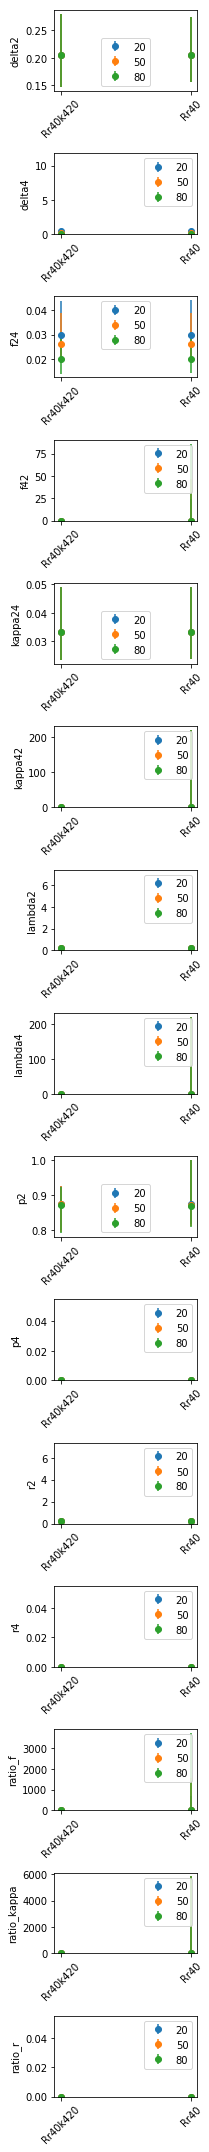

In [34]:
p_names = parameters['parameter'].unique()
# paras = [parameters, parameters_young, parameters_old]

fig, axs = plt.subplots(len(p_names), 1, figsize=(3, 30))



ylimits = {'delta2': (0, 1),
           'p2': (0.5, 1.1),
           'p4': (0.5, 1.1),
           'kappa24': (0, 0.5),
           'kappa42': (0, 1.15),
          'ratio_kappa': (0, 10)}

for parameter, ax in zip(p_names, axs):
    data = parameters[parameters['parameter'] == parameter]
    for time, time_data in data.groupby('time'):
        ax.errorbar('model', 'point_estimate', time_data[['ymin', 'ymax']].T.abs().values,
                    data=time_data, marker='o', ls='None', label=time)
        ax.legend()
        ax.set_ylabel(parameter)
#     try:
#         ax.set_ylim(ylimits[parameter])
#     except:
    ylim = ax.get_ylim()
    ax.set_ylim(max(ylim[0], 0), ylim[1])
    ax.tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.show()

### Detailed

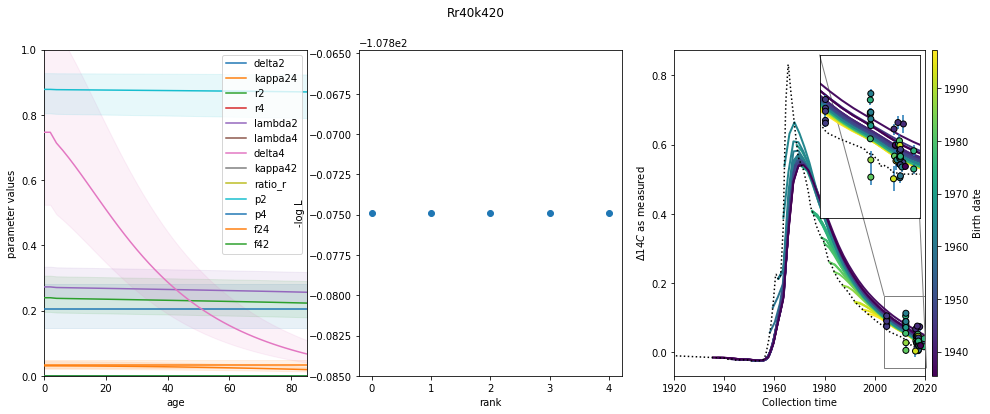

point_estimate      lower      upper
time parameter                                       
0    delta2            0.206108    0.14664   0.280802
     delta4            0.746731   0.524354    1.10075
     f24              0.0304992  0.0214165  0.0449585
     f42                      0          0          0
     kappa24          0.0332122  0.0233215  0.0489577
     kappa42                  0          0          0
     lambda2           0.272532   0.240732   0.334431
     lambda4                  0          0          0
     p2                0.878135   0.804556   0.927986
     p4                       0          0          0
     r2                 0.23932   0.195833   0.306866
     r4                       0          0          0
     ratio_f                  0          0          0
     ratio_kappa              0          0          0
     ratio_r                  0          0          0
50   delta2            0.206108    0.14664   0.280802
     delta4            0.210991   0.137617   0.327798
     f24              0.0261596  0.0183692  0.0385616
     f42                      0          0          0
     kappa24          0.0332122  0.0233215  0.0489577
     kappa42                  0          0          0
     lambda2            0.26299    0.23119   0.324889
     lambda4                  0          0          0
     p2                0.873713   0.796318   0.925721
     p4                       0          0          0
     r2                0.229778   0.186292   0.297325
     r4                       0          0          0
     ratio_f                  0          0          0
     ratio_kappa              0          0          0
     ratio_r                  0          0          0
80   delta2            0.206108    0.14664   0.280802
     delta4           0.0799085  0.0490279   0.129069
     f24              0.0202443  0.0142155  0.0298418
     f42                      0          0          0
     kappa24          0.0332122  0.0233215  0.0489577
     kappa42                  0          0          0
     lambda2           0.257295   0.225494   0.319194
     lambda4                  0          0          0
     p2                0.870918   0.791301     0.9241
     p4                       0          0          0
     r2                0.224083   0.180596   0.291629
     r4                       0          0          0
     ratio_f                  0          0          0
     ratio_kappa              0          0          0
     ratio_r                  0          0          0
100  delta2            0.206108    0.14664   0.280802
     delta4           0.0785061  0.0551269   0.115725
     f24              0.0179904  0.0126328  0.0265195
     f42                      0          0          0
     kappa24          0.0332122  0.0233215  0.0489577
     kappa42                  0          0          0
     lambda2           0.272532   0.240732   0.334431
     lambda4                  0          0          0
     p2                0.878135   0.804556   0.927986
     p4                       0          0          0
     r2                 0.23932   0.195833   0.306866
     r4                       0          0          0
     ratio_f                  0          0          0
     ratio_kappa              0          0          0
     ratio_r                  0          0          0

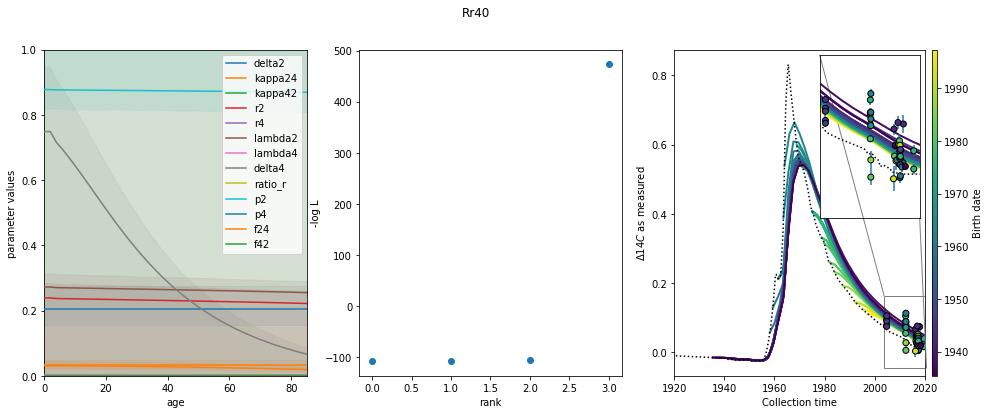

point_estimate        lower      upper
time parameter                                         
0    delta2            0.205517     0.156808   0.274568
     delta4            0.748808     -219.408   0.944406
     f24              0.0306266    0.0218675  0.0451703
     f42            8.51442e-05  1.51632e-09    18.0114
     kappa24          0.0333509    0.0238127  0.0491883
     kappa42         0.00104232  1.85626e-08    220.493
     lambda2           0.272127     -19.3209   0.311878
     lambda4         0.00104232  1.85626e-08    220.493
     p2                0.877443     0.819863    1.00002
     p4                       0            0          0
     r2                0.238776     -19.3691   0.282738
     r4                       0            0          0
     ratio_f         0.00278008  4.67677e-08    519.635
     ratio_kappa      0.0312532  5.25755e-07    5841.65
     ratio_r                  0            0          0
50   delta2            0.205517     0.156808   0.274568
     delta4            0.210977      -220.17   0.267119
     f24              0.0262689    0.0187561  0.0387432
     f42            0.000221336  3.94174e-09    46.8214
     kappa24          0.0333509    0.0238127  0.0491883
     kappa42         0.00104232  1.85626e-08    220.493
     lambda2           0.262396     -59.1612   0.298949
     lambda4         0.00104232  1.85626e-08    220.493
     p2                0.872899     0.812945     1.0001
     p4                       0            0          0
     r2                0.229046     -59.2094   0.269088
     r4                       0            0          0
     ratio_f         0.00842578  1.41742e-07     1574.9
     ratio_kappa      0.0312532  5.25755e-07    5841.65
     ratio_r                  0            0          0
80   delta2            0.205517     0.156808   0.274568
     delta4           0.0792993     -220.366   0.101525
     f24              0.0203288    0.0145149  0.0299824
     f42            0.000406981  7.24788e-09    86.0929
     kappa24          0.0333509    0.0238127  0.0491883
     kappa42         0.00104232  1.85626e-08    220.493
     lambda2           0.256314     -140.964   0.289479
     lambda4         0.00104232  1.85626e-08    220.493
     p2                0.869883     0.809565    1.00027
     p4                       0            0          0
     r2                0.222963     -141.012   0.260452
     r4                       0            0          0
     ratio_f          0.0200199  3.36784e-07       3742
     ratio_kappa      0.0312532  5.25755e-07    5841.65
     ratio_r                  0           -0          0
100  delta2            0.205517     0.156808   0.274568
     delta4           0.0777917     -220.379   0.094446
     f24              0.0180656    0.0128989  0.0266444
     f42            0.000477715  8.50758e-09    101.056
     kappa24          0.0333509    0.0238127  0.0491883
     kappa42         0.00104232  1.85626e-08    220.493
     lambda2           0.271337     -186.267   0.304716
     lambda4         0.00104232  1.85626e-08    220.493
     p2                0.877087     0.822282    1.00026
     p4                       0            0          0
     r2                0.237986     -186.316   0.275244
     r4                       0            0          0
     ratio_f          0.0264434  4.44843e-07    4942.65
     ratio_kappa      0.0312532  5.25755e-07    5841.65
     ratio_r                  0           -0          0

In [38]:
for name, result in results.items():
    if name not in ['']:
        no_plot = ['ratio_kappa', 'ratio_f']
        fig, axs = plt.subplots(1, 3, figsize=(16,6))
        fig.suptitle(name)
        result['vis'].plot_parameter(result['point_estimate'], result['errors'],
                                         no_plot=no_plot, axis=axs[0])
#         result['vis'].plot_parameter(result['point_estimate'], 
#                                          no_plot=no_plot, axis=axs[0])

        axs[0].legend()
        axs[0].set_ylabel('parameter values')
        axs[0].set_ylim(0, 1)
        axs[0].set_xlim(0, 85)

        fval = result['multistart_result']['fval']
        axs[1].scatter(np.arange(len(fval)), fval.values)
        axs[1].set_xlabel('rank')
        axs[1].set_ylabel('-log L')
    #         axs[1].set_xlim(0, 100)
        
        _ = result['vis'].odeint()
        result['vis'].plot_simdata( axis=axs[2], cmap=plt.cm.viridis)
        axs[2].set_xlim(1920, 2020)

        plt.show()

        try:
            display(result['vis'].get_parameter(result['point_estimate'], result['cov'], t_eval=[0, 50, 80, 100], ignore_physics=True
                                               ))
        except:
            pass

## Export

In [39]:
# model = 'A'

# time = np.linspace(0, 100, 101)
# df = pd.DataFrame(results[model]['model'].get_implicit_parameters(time))[['r2', 'kappa24', 'ratio_r', 'p']]
# # df.columns=['r2', 'r4', 'kappa24', 'kappa42', 'ratio_r']
# df['r4'] = results[model]['model'].r4
# df['kappa42'] = results[model]['model'].kappa42
# df['delta2'] = results[model]['model'].delta2
# df['delta4'] = results[model]['model'].delta4
# df['age'] = time
# df['ploidy'] = c14.models.liver.A().ploidy(df['age'])
# df.head()

# result = results[model]
# df = result['vis'].get_parameter(result['point_estimate'], result['cov'], t_eval=time).unstack().reset_index()

# df = df[['time', 'point_estimate']]

# df.to_excel('../../../results/parameters_A.xlsx')

## Model selection

In [40]:
# _ = results.pop('POP1', None)

In [41]:
model_selection_results = pd.DataFrame(
    pd.Series(
        {name: result['op'].calc_aicc(result['point_estimate'])
         for name, result in results.items()}, name='cAIC'))
model_selection_results['loglike'] = [result['op'].loglike_dict(result['point_estimate']) for name, result in results.items()]
model_selection_results['nparas'] = [result['model'].nparas for name, result in results.items()] 
model_selection_results['nparas'] += 1
model_selection_results = pd.DataFrame(model_selection_results)
model_selection_results['delta'] = model_selection_results['cAIC'] - model_selection_results['cAIC'].min() 
model_selection_results['w'] = np.exp(-0.5*model_selection_results['delta']) / np.exp(-0.5*model_selection_results['delta']).sum()
model_selection_results['ER'] = model_selection_results['w'].max() / model_selection_results['w']
model_selection_results.sort_values('cAIC')

,cAIC,loglike,nparas,delta,w,ER
Rr40k420,-209.164394,107.874880,3,0.000000,0.770945,1.000000
Rr40,-206.737086,107.868543,4,2.427308,0.229055,3.365761


In [ ]:
# parameters = parameters.merge(model_selection_results, left_on='model', right_index=True)

In [ ]:
# parameters['log10_point_estimate'] = np.log10(parameters['point_estimate'])
# parameters['log10_lower'] = np.log10(parameters['lower'])
# parameters['log10_upper'] = np.log10(parameters['upper'])
# parameters.head()

# parameters['log10_error_lower'] = parameters['log10_point_estimate'] - parameters['log10_lower']
# parameters['log10_error_upper'] = -parameters['log10_point_estimate'] + parameters['log10_upper']

# parameters['log10_error'] = parameters[['log10_error_lower', 'log10_error_upper']].mean(axis='columns')

# parameters.head()

# def parameter_average(data):
#     parameter = data['parameter'].iloc[0]
#     log10_mean = np.average(data['log10_point_estimate'], weights=data['w'])
#     log10_error = np.average(
#         np.sqrt(data['log10_error']**2 + (data['log10_point_estimate'] - log10_mean)**2),
#         weights=data['w'])
#     point_estimate = 10**log10_mean
#     lower = 10**(log10_mean-log10_error)
#     upper = 10**(log10_mean+log10_error)
#     return pd.Series({
#         'point_estimate': point_estimate,
#         'lower': lower,
#         'upper': upper,
#         'model': 'average',
#         'ymin': point_estimate - lower,
#         'ymax': point_estimate + upper,
#         'log10_point_estimate': log10_mean,
#         'log10_error': log10_error
#     })

# rates = ["r2", "r4", "delta2", "delta4", "kappa24", "kappa42", "lambda2", "lambda4"]

# averaged_parameters = (parameters
#                        .query('parameter in @rates')
#                        .groupby(['time', 'parameter'])
#                        .apply(parameter_average)
#                        .reset_index()
#                         )

In [ ]:
# parameters = pd.concat([parameters, averaged_parameters], axis='rows', sort=False)

In [ ]:
# p_names = parameters['parameter'].unique()
# paras = 3*[parameters]
# fig, axss = plt.subplots(len(p_names), len(paras), figsize=(9, 30))



# ylimits = {'delta2': (0, 2),
#            'delta4': (0, 1),
#            'lambda2': (0, 2),
#            'r2': (0, 2),
#            'p2': (0.5, 1.1),
#            'p4': (0.5, 1.1),
#            'kappa24': (0, 0.2),
#           'ratio_kappa': (0, 10)}

# for parameter, axs in zip(p_names, axss):
#     for para, ax in zip(paras, axs):
#         data = para[para['parameter'] == parameter]
#         for time, time_data in data.groupby('time'):
#             ax.errorbar('model', 'point_estimate', time_data[['ymin', 'ymax']].T.abs().values,
#                         data=time_data, marker='o', ls='None', label=time)
#             ax.legend()
#             ax.set_ylabel(parameter)
#         try:
#             ax.set_ylim(ylimits[parameter])
#         except:
#             ax.set_ylim(0, 1)
#         ax.tick_params(axis='x', labelrotation=45)

# plt.tight_layout()
# plt.show()